#  The Challenge: Soil organic matter content (SOM) prediction (Spectroscopic Based Method)
**Objectives:**

1.   Familiarize with the dataset (inspect and clean data).
2.   Compare the estimates **SOM** with the corresponding data
 from POLARIS soil database (Identify, Download, and ExtractPOLARIS data).
3.   Build two models and Evaluate their performance (using the sensor readings and
lab values) to predict **SOM** of closeby fields. 
**Data:**
1. [STENON challege data](https://drive.google.com/file/d/1wHEEg3O9Cjj3cj77j55egPDbJuiOHDBj/view?usp=sharing)
2. [The POLARIS soil database](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/)

**Reference (ANN model result):**

1. https://agupubs.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1029%2F2018WR022797&file=wrcr23830-sup-0001-Text_SI-S01.pdf

##Objectives

1.   Familiarize with the dataset (inspect and clean data).
2.   Compare the estimates **SOM** with the corresponding data
 from POLARIS soil database (Identify, Download, and ExtractPOLARIS data).
3.   Build two models and Evaluate their performance (using the sensor readings and
lab values) to predict **SOM** of closeby fields.

##Data
1. [STENON challenge data](https://drive.google.com/file/d/1wHEEg3O9Cjj3cj77j55egPDbJuiOHDBj/view?usp=sharing)
2. [The POLARIS soil database](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/)


## Reference (ANN model result)

1. https://agupubs.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1029%2F2018WR022797&file=wrcr23830-sup-0001-Text_SI-S01.pdf

# Setup program's requirements

## Install the requirement packages

In [1]:
# Install the Python package to view the map on google maps
!pip install geemap --quiet

# # Install the Python package to plot charts
# !pip install matplotlib==3.1.1 --quiet

# Install the Python package to download data from website
!pip install wget --quiet

# Install the Python package to handle geo-vector and raster data
!pip install rasterstats --quiet

# # Install the Python package to created to manipulate data geo-vector data
# !pip install geopandas --quiet  # Might introduce conflict

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git --quiet
# Install descartes - Geopandas requirment
!pip install descartes --quiet
# Install Folium for Geographic data visualization
!pip install folium --quiet
# Install plotlyExpress
!pip install plotly_express --quiet

     |████████████████████████████████| 1.9 MB 5.5 MB/s 
     |████████████████████████████████| 8.7 MB 37.4 MB/s 
     |████████████████████████████████| 99 kB 8.2 MB/s 
     |████████████████████████████████| 130 kB 44.1 MB/s 
     |████████████████████████████████| 216 kB 13.8 MB/s 
     |████████████████████████████████| 1.3 MB 42.1 MB/s 
     |████████████████████████████████| 1.7 MB 42.6 MB/s 
     |████████████████████████████████| 95 kB 3.6 MB/s 
     |████████████████████████████████| 98 kB 4.3 MB/s 
     |████████████████████████████████| 76 kB 2.3 MB/s 
     |████████████████████████████████| 5.4 MB 33.4 MB/s 
     |████████████████████████████████| 3.3 MB 64.2 MB/s 
     |████████████████████████████████| 44 kB 2.1 MB/s 
     |████████████████████████████████| 1.2 MB 10.2 MB/s 
     |████████████████████████████████| 187 kB 42.0 MB/s 
     |████████████████████████████████| 97 kB 5.7 MB/s 
     |████████████████████████████████| 397 kB 39.5 MB/s 
     |█████████████████████

##Import Standard libraries

In [2]:
import os
import sys
import math
import logging
import argparse

from urllib.parse import urlparse

logger = logging.getLogger(__name__)
# import multiprocessing

## Import Third party libraries


In [3]:
import ee

import math
import wget
import json
import csv
import folium
import geojson
import numpy as np
import pandas as pd

import scipy as sp
from scipy.stats import pearsonr
from scipy.interpolate import interpn
from scipy.spatial.distance import pdist, squareform

import geemap
import geopandas as gpd
from rasterstats import point_query
from shapely.geometry import shape, GeometryCollection
from geojson import Feature, FeatureCollection, Point

# Third party imports to plot pretty figures
%matplotlib inline
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import Normalize

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

font      = {'family':'arial', 'style':'normal', 'size':18}
axis_font = {'family':'arial', 'style':'normal', 'size':18}
plt.rc('font', **font)

import seaborn as sns
sns.set(style = 'whitegrid')

# Colab includes an extension that renders pandas dataframes into interactive displays 
# that can be filtered, sorted, and explored dynamically.
from google.colab import files
from google.colab import data_table
data_table.disable_dataframe_formatter()
data_table.DataTable.max_columns = 30

# Enable vertical scrolling in code block/output block
from IPython.display import display, HTML
js = "<script>$('.output_scroll').removeClass('output_scroll')</script>"
display(HTML(js))

## Earth Engine authentication

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

## Google Driver authentication (optional)

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

#Challenge actions

## Familiarize with the dataset

In [ ]:
uploaded = files.upload()
csv_fn = next(iter(uploaded))

###Read csv file input

In [7]:
def csv_valid(infile, arbitrary_number=2048):
  #arbitrary_number is an entirely arbitrary number. It just needs to be big enough to read in at least two or three CSV rows. 
  with open(infile, 'rb') as csvfile:
    try:
      sniffer = csv.Sniffer()
      dialect = sniffer.sniff(csvfile.read(arbitrary_number))
      # Perform various checks on the dialect (e.g., lineseparator, delimiter) to make sure it's sane
      delimiter = dialect.delimiter
      lineseparator = dialect.lineterminator
      # Reset the read position back to the start of the file before reading any entries.
      csvfile.seek(0)

      # Perform header check to make sure it's sane
      has_header = sniffer.has_header(csvfile.read(arbitrary_number))
      logger.info("CSV file is OK!")

      return delimiter, lineseparator, has_header
    except csv.Error:
      # File appears not to be in CSV format; move along
      logger.error ("Invalid CSV file")
      return None


st_path = "./{}".format(csv_fn)
# delimiter, _, _ = csv_valid(st_path)

if os.path.exists(st_path):
  df_data = pd.read_csv(st_path, sep=';')
  print(df_data.info)
else:
  print ("{} does not exists. The following code blocks won't be execused. Please check!".format(st_path))

<bound method DataFrame.info of       measurement_ID                   lat_lng location        som  nir_1370  \
0                  0  (41.2799111,-92.0301512)  field_A   2.038524  0.268311   
1                  1  (41.2798524,-92.0294544)  field_A  17.443334  0.411358   
2                  2  (41.2798545,-92.0294499)  field_A   2.227260  0.402013   
3                  3   (41.2796759,-92.027938)  field_A   2.369437  0.506582   
4                  4   (41.2796802,-92.027932)  field_A   2.345968  0.475707   
...              ...                       ...      ...        ...       ...   
1068            1068  (41.2718012,-92.0390603)  field_B   1.919485  0.421228   
1069            1069  (41.2717968,-92.0390726)  field_B   1.702884  0.451167   
1070            1070  (41.2717812,-92.0374845)  field_B   1.555839  0.489369   
1071            1071  (41.2717374,-92.0375016)  field_B   1.644490  0.507497   
1072            1072  (41.2717458,-92.0374918)  field_B   1.591437  0.447848   

      n

### Inspect the input data and do primary data cleanning
1. Identify missing/incomplete/duplicate record(s) 
2. Drop missing/incomplete/duplicate record(s) 

#### Data inspection (optional)

In [8]:
# print(df_data.head(2))

In [9]:
# print(df_data.tail(2))

In [10]:
# df_data.describe()

In [11]:
# data_table.DataTable(df_data, include_index=False, num_rows_per_page=10)

In [12]:
# data_table.DataTable(df_data.filter(regex='nir_').describe(), include_index=False, num_rows_per_page=10)

####Primary data cleaning

In [13]:
# Count number of Rows having NaN or Empty element(s)
nrows_having_NaN = df_data.shape[0] - df_data.dropna().shape[0]
print ("Total number of Rows contain NaN or Empty element(s): {}".format(nrows_having_NaN))

Total number of Rows contain NaN or Empty element(s): 21


In [14]:
nrows_index_having_NaN = df_data.index[df_data.isnull().any(axis=1)]
print ("Following Rows: {} having NaN or Empty element(s)".format(nrows_index_having_NaN.tolist()))
df_data.iloc[nrows_index_having_NaN.tolist()]

Following Rows: [6, 7, 12, 148, 380, 410, 459, 548, 549, 605, 817, 827, 942, 943, 956, 1039, 1042, 1056, 1059, 1063, 1068] having NaN or Empty element(s)


,measurement_ID,lat_lng,location,som,nir_1370,nir_1374,nir_1378,nir_1382,nir_1386,nir_1390,...,nir_2486,nir_2490,nir_2494,nir_2498,nir_2502,nir_2506,nir_2510,nir_2514,nir_2518,nir_2522
6,6,"(41.2796451,-92.0272683)",field_A,2.404789,0.458376,0.455395,0.450467,0.443263,0.433917,0.422832,...,0.203755,0.201477,0.199492,0.197807,0.196425,0.195351,0.194587,0.194137,0.194004,0.194193
7,7,"(41.2785352,-92.0258246)",field_A,2.274771,0.405309,0.402589,0.397344,0.389162,0.378638,0.366896,...,0.161977,0.160195,0.158629,0.157287,0.156176,0.155300,0.154666,0.154279,0.154144,0.154269
12,12,"(41.2789834,-92.0271847)",field_A,2.368392,0.429245,0.426400,0.421677,0.414607,0.405291,0.394182,...,0.180110,0.178271,0.176629,0.175192,0.173965,0.172953,0.172160,0.171592,0.171254,0.171149
148,148,"(41.2749801,-92.0302816)",field_A,NaN,0.548440,0.544507,0.539130,0.531397,0.520869,0.507597,...,0.233458,0.230943,0.228500,0.226186,0.224060,0.222180,0.220608,0.219403,0.218624,0.218331
380,380,"(41.2744286,-92.0309851)",field_A,2.243380,0.262801,0.259948,0.256718,0.252900,0.248281,0.242464,...,0.149032,0.147511,NaN,0.145008,0.144056,0.143315,0.142793,0.142499,0.142443,0.142631
410,410,"(41.2755399,-92.0302769)",field_A,2.087054,0.391038,0.388326,0.384833,0.379096,0.370173,0.359023,...,0.159687,0.157733,0.156086,0.154769,0.153770,0.153076,0.152673,0.152548,0.152688,0.153080
459,459,"(41.2767103,-92.0294227)",field_A,1.672700,0.366341,0.364446,0.360978,NaN,0.350085,0.343373,...,0.177333,0.175782,0.174269,0.172827,0.171495,0.170306,0.169299,0.168508,0.167970,0.167716
548,548,"(41.276149,-92.0317264)",field_A,1.859473,0.474475,0.470377,0.464071,0.455043,0.443431,0.429572,...,0.182306,0.180258,0.178296,0.176461,0.174797,0.173346,0.172151,0.171255,0.170701,0.170528
549,549,"(41.2761434,-92.0309735)",field_A,1.928195,0.474540,0.471533,0.466922,0.459742,0.450156,0.438694,...,0.199251,0.197084,0.194992,0.193020,0.191218,0.189635,0.188319,0.187320,0.186686,0.186459
605,605,"(41.2749934,-92.0271311)",field_A,2.118079,0.465279,0.461459,0.455300,0.446164,0.434476,NaN,...,0.162110,0.160218,0.158387,0.156663,0.155089,0.153713,0.152578,0.151732,0.151219,0.151080


In [15]:
# # Select duplicate rows except first occurrence based on all columns
# duplicateRowsDF = df_data[df_data.duplicated()]
# print("Duplicate Rows except first occurrence based on all columns are :")
# print(duplicateRowsDF)

# for col in ['measurement_ID', 'lat_lng']:
#   # Select all duplicate rows based on one column
#   duplicateRowsDF = df_data[df_data.duplicated([col])]
#   print("Duplicate Rows based on a single column are:", duplicateRowsDF, sep='\n')

In [16]:
# Count number of Rows having  all element are NaN or Empty
nrows_all_NaN = df_data.shape[0] - df_data.isnull().all(axis=1).shape[0] 
print ("Total number of Rows having  all elements are NaN or Empty: {}".format(nrows_all_NaN))

if nrows_all_NaN> 0:
    print (df_data.loc[nrows_all_NaN])
    df_data = df_data.loc[df_data.index.drop(nrows_all_NaN)]

Total number of Rows having  all elements are NaN or Empty: 0


In [17]:
# Drop Rows with missing values or NaN
df_data = df_data.dropna()

# Extract wave length
wave_length = [int(item.split('_')[1]) for item in df_data.columns.tolist() if 'nir_' in item]
print (wave_length)

# Columns of Interest
ioc_name = [col for col in df_data.columns if (("nir_" in col) and (df_data[col].dtype == "float64"))]
print (ioc_name)

[1370, 1374, 1378, 1382, 1386, 1390, 1394, 1398, 1402, 1406, 1410, 1414, 1418, 1422, 1426, 1430, 1434, 1438, 1442, 1446, 1450, 1454, 1458, 1462, 1466, 1470, 1474, 1478, 1482, 1486, 1490, 1494, 1498, 1502, 1506, 1510, 1514, 1518, 1522, 1526, 1530, 1534, 1538, 1542, 1546, 1550, 1554, 1558, 1562, 1566, 1570, 1574, 1578, 1582, 1586, 1590, 1594, 1598, 1602, 1606, 1610, 1614, 1618, 1622, 1626, 1630, 1634, 1638, 1642, 1646, 1650, 1654, 1658, 1662, 1666, 1670, 1674, 1678, 1682, 1686, 1690, 1694, 1698, 1702, 1706, 1710, 1714, 1718, 1722, 1726, 1730, 1734, 1738, 1742, 1746, 1750, 1754, 1758, 1762, 1766, 1770, 1774, 1778, 1782, 1786, 1790, 1794, 1798, 1802, 1806, 1810, 1814, 1818, 1822, 1826, 1830, 1834, 1838, 1842, 1846, 1850, 1854, 1858, 1862, 1866, 1870, 1874, 1878, 1882, 1886, 1890, 1894, 1898, 1902, 1906, 1910, 1914, 1918, 1922, 1926, 1930, 1934, 1938, 1942, 1946, 1950, 1954, 1958, 1962, 1966, 1970, 1974, 1978, 1982, 1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022, 2026, 2030, 203

####Further data inspection via chartplot(s)

In [ ]:
def density_scatter(df, field_name, xcol='nir_2522', ycol='som', ax = None, sort=True, bins=20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """

    x = df_field[xcol].to_numpy()
    y = df_field[ycol].to_numpy()

    if ax is None :
        fig , ax = plt.subplots(figsize=(10, 8))
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    plt.xlabel(xcol, fontsize=16)
    plt.ylabel(ycol, fontsize=16)

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density', fontsize=18)
    ax.set_title ("{} (n_obs = {})".format(field_name, df_field[xcol].shape[0]), fontsize=18)
    plt.show()

    return ax


for location_name in set(df_data['location'].tolist()):
  df_field = df_data[df_data['location'] == location_name]
  df_field_nir = df_field.filter(regex='nir_')
  plt.figure(figsize=(25, 10))
  plt.clf

  for _, row in df_field_nir.iterrows():
      plt.plot(wave_length, 100*row, linewidth=0.5)

  plt.xlabel("Wavelength [nm]", fontsize=16)
  plt.ylabel("Soil reflectance [%]", fontsize=16)
  plt.title ("{} (spectroscopic measurements data, n_obs={} samples)".format(location_name, df_field.shape[0]), fontsize=18)
  plt.legend()

for location_name in set(df_data['location'].tolist()):
  df_field = df_data[df_data['location'] == location_name]
  plt.figure(figsize=(25, 10))
  plt.clf

  plt.hist(df_field['som'], bins=100, histtype='bar', rwidth=0.8)
  plt.xlim(df_field['som'].min(), df_field['som'].max())
  plt.xlabel("SOM [%]", fontsize=16)
  plt.title ("{} (soil organic matter content data, n_obs = {} samples)".format(location_name, df_field['som'].shape[0]), fontsize=18)
  plt.legend()

for location_name in set(df_data['location'].tolist()):
  df_field = df_data[df_data['location'] == location_name]
  density_scatter(df_field, location_name, xcol='nir_1902', ycol='som', bins=[100,100])

In [19]:
# g = sns.FacetGrid(df_data, col="location", margin_titles=True, height=4)
# g.map(plt.scatter, "nir_2522", "som", color="#338844", edgecolor="white", s=50, lw=1)

In [20]:
# sns.lmplot('nir_1370', 'nir_2522', data=df_data, fit_reg=True)

####Geo-location data inspection

In [21]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)


# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Conver pandas dataframe into geojson format
def pandas_to_geojson(df, out_geojson=None, latitude_longitude="lat_lng", encoding="utf-8",):
  """Creates points for a Pandas DataFrame and exports data as a GeoJSON.

  Args:
      df (pandas.DataFrame): The input Pandas DataFrame.
      out_geojson (str): The file path to the exported GeoJSON. Default to None.
      latitude (str, optional): The name of the column containing latitude coordinates. Defaults to "latitude".
      longitude (str, optional): The name of the column containing longitude coordinates. Defaults to "longitude".
      encoding (str, optional): The encoding of characters. Defaults to "utf-8".

  """

  if out_geojson is not None:
    out_dir = os.path.dirname(os.path.abspath(out_geojson))
    if not os.path.exists(out_dir):
      os.makedirs(out_dir)

  features = df.apply(
    lambda row: Feature(
        geometry=Point((float(row['lat_lng'][1:-1].split(',')[1]), float(row['lat_lng'][1:-1].split(',')[0]))),
        properties=dict(row),
    ),
    axis=1,
  ).tolist()

  geojson_obj = FeatureCollection(features=features)
  coords = np.array(list(geojson.utils.coords(geojson_obj)))

  #delete [0, 0] from coords
  # coords = np.delete(coords, [0, 0], axis=0)
  area_extent = coords[:,0].min(), coords[:,0].max(), coords[:,1].min(), coords[:,1].max()

  if out_geojson is None:
    return [False, geojson_obj, area_extent]
  else:
    with open(out_geojson, "w", encoding=encoding) as f:
      f.write(json.dumps(geojson_obj))
    return [True, geojson_obj, area_extent]

In [22]:
# df_data = df_data[df_data['lat_lng'] != '(0,0)']
_, geojson_obj, area_extent = pandas_to_geojson(df_data.iloc[:, :4])
fc = geemap.geojson_to_ee(geojson_obj)

Map = geemap.Map(center=(0, 0), zoom=3, lite_mode=True)
Map.addLayer(fc, {}, 'csv to ee 2')
Map

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [23]:
df_data = df_data[df_data['lat_lng'] != '(0,0)']
_, geojson_obj, area_extent = pandas_to_geojson(df_data.iloc[:, :4])
fc = geemap.geojson_to_ee(geojson_obj)

Map = geemap.Map(center=(0, 0), zoom=3, lite_mode=True)
Map.addLayer(fc, {}, 'csv to ee 2')
Map

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

### Handle missing and outlier matter(s) in the data


####Handle wrong geo-location data

In [24]:
_temp_geo = df_data["lat_lng"].str.slice(start=1,stop=-1).str.split(",", n = 1, expand = True)
df_data["lat"] = _temp_geo[0]
df_data['lng'] = _temp_geo[1]
df_data[["lat", "lng"]] = df_data[["lat", "lng"]].apply(pd.to_numeric)
lat_median = df_data["lat"].median()
lon_median = df_data["lng"].median()

In [25]:
_, geojson_obj, area_extent = pandas_to_geojson(df_data.iloc[:, :4])
fc = geemap.geojson_to_ee(geojson_obj)

Map = geemap.Map(center=(lat_median, lon_median), zoom=15, lite_mode=True)
# https://viewer.nationalmap.gov/services/
url = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'
Map.add_tile_layer(url, name='Google Satellite', attribution='Google')
Map.addLayer(fc, {}, 'csv to ee 2')
Map

Map(center=[41.2738562, -92.0308867], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

In [26]:
_, geojson_obj, area_extent = pandas_to_geojson(df_data.iloc[:, :4][df_data['location']== 'field_A'])
fc = geemap.geojson_to_ee(geojson_obj)

Map = geemap.Map(center=(lat_median, lon_median), zoom=15, lite_mode=True)
# https://viewer.nationalmap.gov/services/
url = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'
Map.add_tile_layer(url, name='Google Satellite', attribution='Google')
Map.addLayer(fc, {}, 'csv to ee 2')
Map

Map(center=[41.2738562, -92.0308867], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

In [27]:
_, geojson_obj, area_extent = pandas_to_geojson(df_data.iloc[:, :4][df_data['location']== 'field_B'])
fc = geemap.geojson_to_ee(geojson_obj)

Map = geemap.Map(center=(lat_median, lon_median), zoom=15, lite_mode=True)
# https://viewer.nationalmap.gov/services/
url = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'
Map.add_tile_layer(url, name='Google Satellite', attribution='Google')
Map.addLayer(fc, {}, 'csv to ee 2')
Map

Map(center=[41.2738562, -92.0308867], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

In [28]:
# # states = ee.FeatureCollection("TIGER/2018/States")
# # style = {'color': 'black', 'fillColor': "00000000"}
# # Map.addLayer(states.style(**style), {}, "US States")

# Map.remove_labels()

# Map = geemap.Map(center=(lat_median, lon_median), zoom=16, lite_mode=True, add_google_map=True)
# # https://viewer.nationalmap.gov/services/
# url = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'
# Map.add_tile_layer(url, name='Google Satellite', attribution='Google')
# # Labeling a Pandas DataFrame
# Map.add_labels(
#     df_data[['location', 'lat', 'lng', 'som']],
#     "location",
#     x='lng',
#     y='lat',
#     font_size="16pt",
#     font_color="red",
#     font_family="arial",
#     # font_weight="bold",
# )
# Map

In [29]:
_,geojson_obj, extent = pandas_to_geojson(df_data, './data.geojson')
if geojson_obj is True:
  print ('You can start download geojson file []./data.geojson] for further local data inspection and correction')
else:
  print ('You would like to go further with data inspection in Colab!')

You would like to go further with data inspection in Colab!


In [30]:
uploaded = files.upload()
fields_boundary_fn = next(iter(uploaded))

Saving fields_boundary.geojson to fields_boundary.geojson


In [31]:
poly_gdf = gpd.read_file('./{}'.format(fields_boundary_fn))
point_gdf = gpd.GeoDataFrame.from_features(geojson_obj['features'], crs=4326)
# print(point_gdf)

# Make sure they're using the same projection reference before perform geometry Joins
if point_gdf.crs == poly_gdf.crs:
  join_inner_gdf = point_gdf.sjoin(poly_gdf, how="inner")
else:
  print ('The projection reference not the same!')

join_inner_gdf.rename({'location_right': 'location', 'location_left': 'location_orig'}, axis=1, inplace=True)
df_data_correct_geo = pd.DataFrame(join_inner_gdf.drop(columns='geometry'))

In [32]:
df_data_correct_geo.shape

(1051, 298)

In [33]:
# # states = ee.FeatureCollection("TIGER/2018/States")
# # style = {'color': 'black', 'fillColor': "00000000"}
# # Map.addLayer(states.style(**style), {}, "US States")

# Map.remove_labels()

# Map = geemap.Map(center=(lat_mean, lon_mean), zoom=16, lite_mode=True, add_google_map=True)

# # Labeling a Pandas DataFrame
# Map.add_labels(
#     df_data_correct_geo[['location', 'lat', 'lng', 'som']],
#     "location",
#     x='lng',
#     y='lat',
#     font_size="16pt",
#     font_color="red",
#     font_family="arial",
#     # font_weight="bold",
# )
# Map

No handles with labels found to put in legend.
No handles with labels found to put in legend.


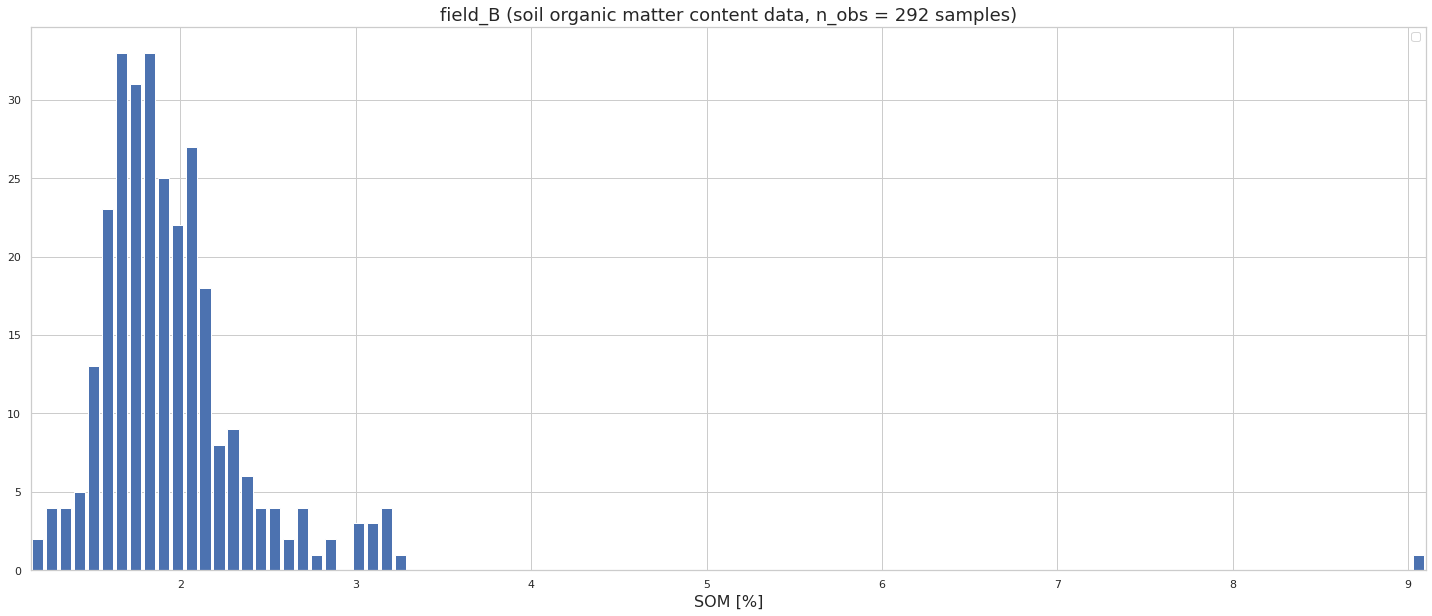

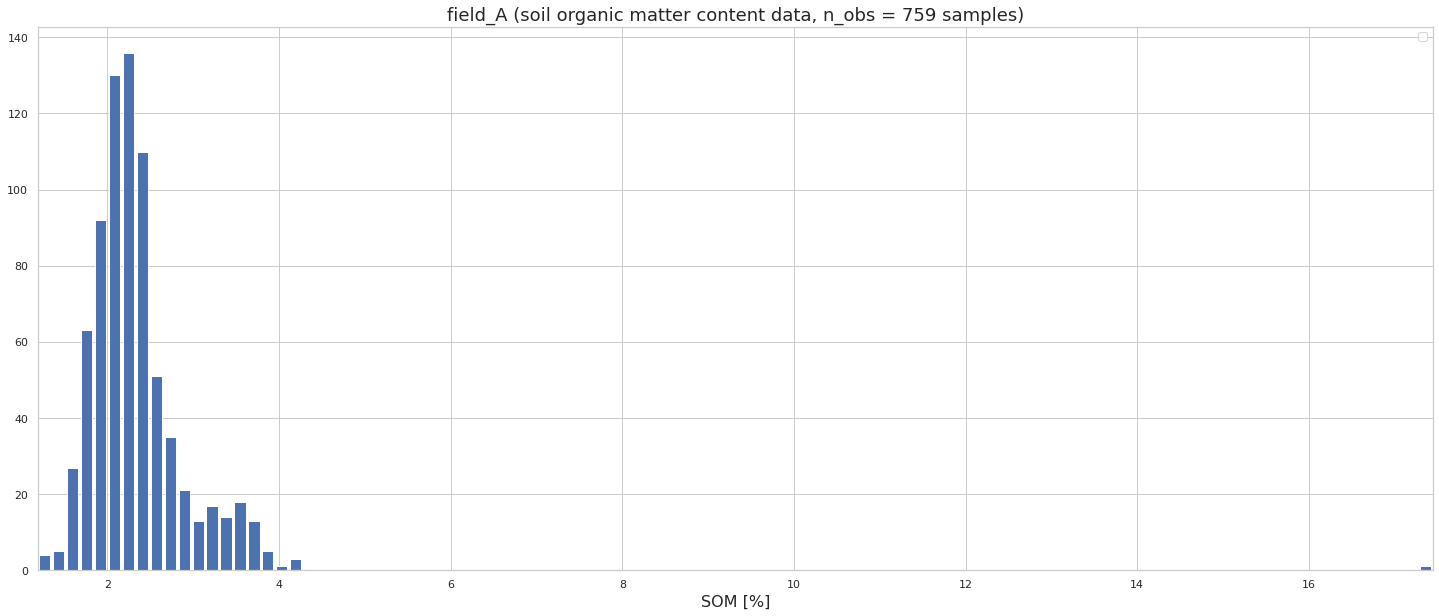

In [34]:
for location_name in set(df_data_correct_geo['location'].tolist()):
  df_field = df_data_correct_geo[df_data_correct_geo['location'] == location_name]
  plt.figure(figsize=(15, 8))
  plt.clf

  plt.hist(df_field['som'], bins=100, histtype='bar', rwidth=0.8)
  plt.xlim(df_field['som'].min(), df_field['som'].max())
  plt.xlabel("SOM [%]", fontsize=16)
  plt.title ("{} (soil organic matter content data, n_obs = {} samples)".format(location_name, df_field['som'].shape[0]), fontsize=18)
  plt.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


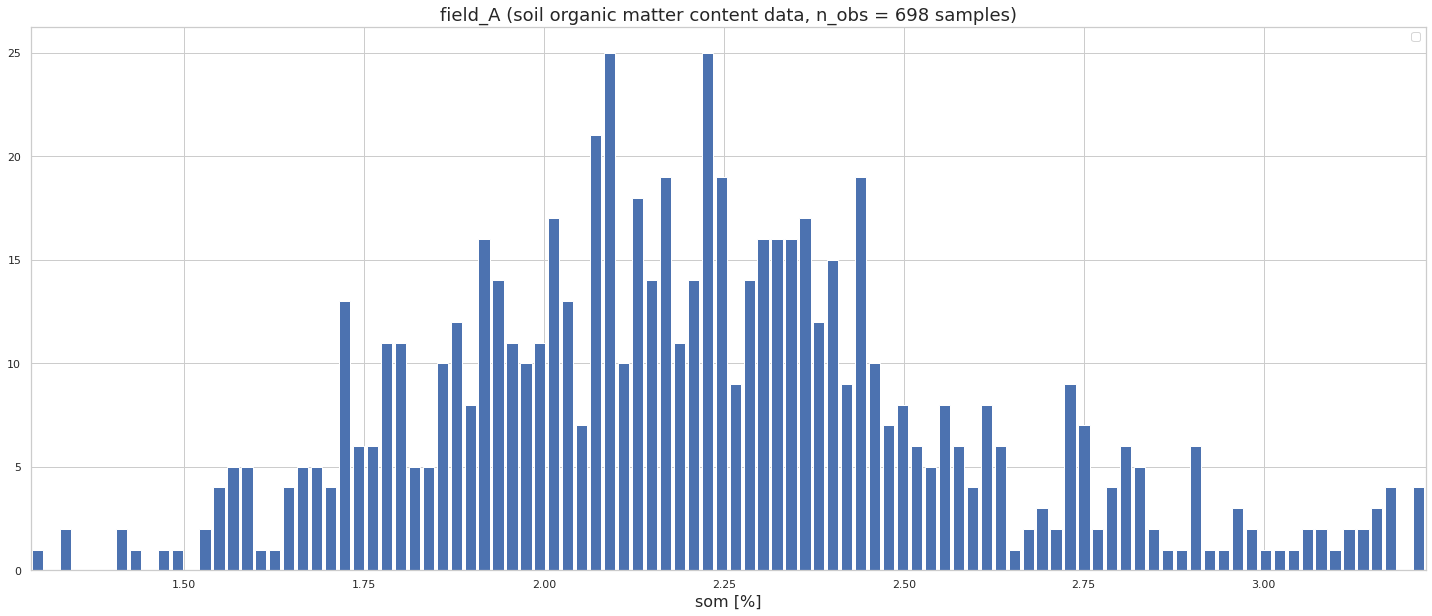

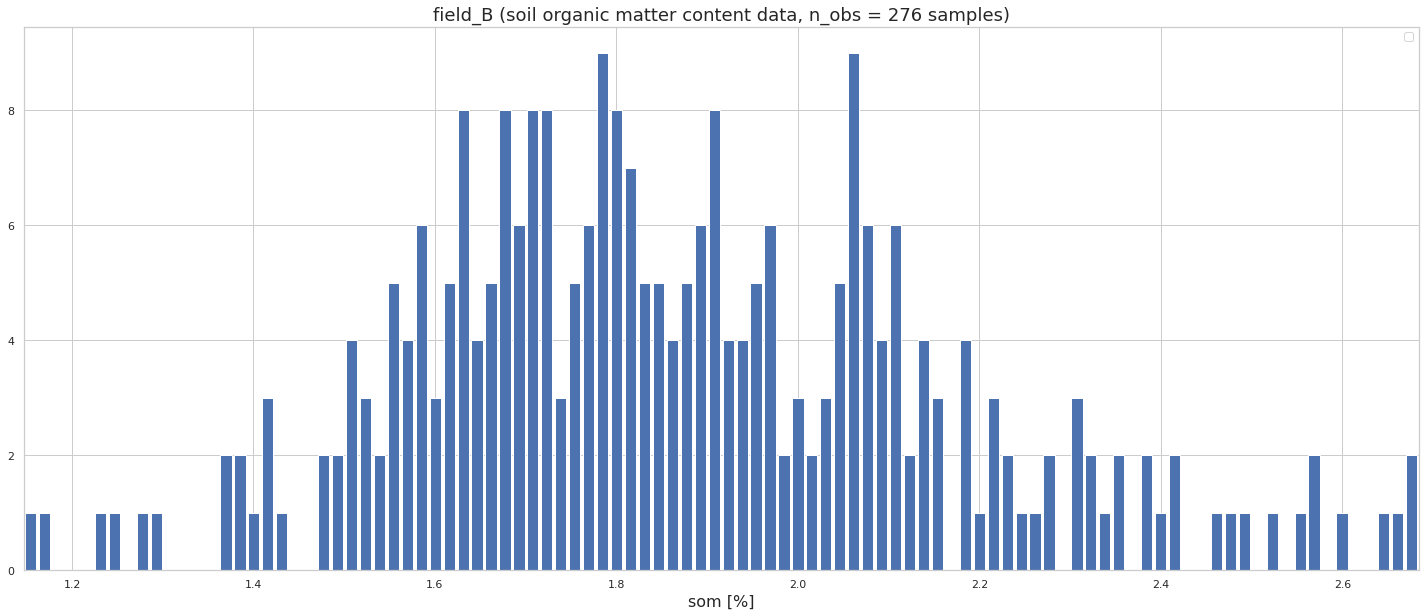

In [35]:
def outlier_removal(df, location_name, col='location', attribute='som'):
  df_field = df[df[col] == location_name]

  Q1 = df_field[attribute].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100)
  Q3 = df_field[attribute].quantile(0.75)
  IQR = Q3 - Q1

  # Return a boolean array of the rows with (any) non-outlier column values
  condition = ~((df_field[attribute] < (Q1 - 1.5 * IQR)) | (df_field[attribute] > (Q3 + 1.5 * IQR)))
  filtered_df_field = df_field.loc[condition]

  plt.figure(figsize=(15, 8))
  plt.clf

  plt.hist(filtered_df_field[attribute], bins=100, histtype='bar', rwidth=0.8)
  plt.xlim(filtered_df_field[attribute].min(), filtered_df_field[attribute].max())
  plt.xlabel("{} [%]".format(attribute), fontsize=16)
  plt.title ("{} (soil organic matter content data, n_obs = {} samples)".format(location_name, filtered_df_field[attribute].shape[0]), fontsize=18)
  plt.legend()

  return filtered_df_field


for location_name in set(df_data_correct_geo['location'].tolist()):
  outlier_removal(df_data_correct_geo, location_name)


##**Compare with POLARIS soil database**

###Identity POLARIS tile(s) data

In [36]:
# Default POLARIS setting values
DEFAULT_POLARIS_URL = 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/{0}/{1}/{2}/lat{3}{4}_lon{5}{6}.tif'

DEFAULT_POLARIS_LAYERS = ['0_5', '5_15', '15_30', '30_60', '60_100', '100_200']
DEFAULT_POLARIS_STATISTICS = ['mean', 'mode', 'p5', 'p50', 'p95']
DEFAULT_POLARIS_PARAMETERS = ['alpha', 'bd', 'clay', 'hb', 'ksat', 'lambda', 'n', 'om', 'ph', 'sand', 'silt', 'theta_r', 'theta_s']

DEFAULT_POLARIS_WORKING_DIRECTORY = './polaris'

layers = DEFAULT_POLARIS_LAYERS
statistics = DEFAULT_POLARIS_STATISTICS
parameters = DEFAULT_POLARIS_PARAMETERS
template_url = DEFAULT_POLARIS_URL

output_base_path = DEFAULT_POLARIS_WORKING_DIRECTORY
os.makedirs(output_base_path, exist_ok=True)

def download_polaris_data(area_extent, output_base_path=output_base_path, layers=layers, statistics=statistics, parameters=parameters):

    # import pdb;pdb.set_trace()
    (minLon, maxLon, minLat, maxLat) = area_extent
    domain_extent = {'lon': [math.floor(minLon), int(math.ceil(maxLon))], 'lat':[math.floor(minLat), int(math.ceil(maxLat))]}

    def generate_url_path(output_base_path, domain_extent):
        ''' TODO': Write discription'''

        url_path_lst = []
        lat_range = range(domain_extent['lat'][0],domain_extent['lat'][1])
        lon_range = range(domain_extent['lon'][0],domain_extent['lon'][1])
        for layer in layers:
            for stat in statistics:
                for param in parameters:
                    for lat in lat_range:
                        for lon in lon_range:
                            url = template_url.format(param,stat,layer,str(lat),str(lat+1),str(lon),str(lon+1))
                            temp_path = os.path.join(output_base_path, '{}/{}/{}/'.format(param,stat,layer))
                            if not os.path.exists(temp_path):
                                os.makedirs(temp_path)
                            url_path_lst += [[url, temp_path]]

        return url_path_lst


    # def run_process(url, output_path):
    #     wget.download(url, out=output_path)


    # Generate URL path for the data that we intersted in
    url_path_lst = generate_url_path(output_base_path, domain_extent)

    # cpus = multiprocessing.cpu_count()
    # max_pool_size = 6
    # pool = multiprocessing.Pool(cpus if cpus < max_pool_size else max_pool_size)

    for url, path in url_path_lst:
        print('Beginning file download with wget module {n}'.format(n=url))
        wget.download(url, out=path)
        # pool.apply_async(run_process, args=(url, path, ))

    # pool.close()
    # pool.join()

    for url, path in url_path_lst:
      if os.path.exists(path):
        print("File(s) in {} downloaded successfully from {}".format(path, url))
      else:
        print("Failed when download file {} from {}".format(path, url))

    return url_path_lst

###Download selected POLARIS tile(s) data

In [37]:
# Default CHALLENGE setting values
DEFAULT_CHALLENGE_LAYERS = ['0_5', '5_15', '15_30']
DEFAULT_CHALLENGE_STATISTICS = ['mean', 'mode', 'p5', 'p50', 'p95']
DEFAULT_CHALLENGE_PARAMETERS = ['om']

_, geojson_obj, area_extent = pandas_to_geojson(df_data_correct_geo_clean, './data.geojson')
url_path_lst = download_polaris_data(area_extent, layers=DEFAULT_CHALLENGE_LAYERS, statistics=DEFAULT_CHALLENGE_STATISTICS, parameters=DEFAULT_CHALLENGE_PARAMETERS)

Beginning file download with wget module http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/om/mean/0_5/lat4142_lon-93-92.tif
Beginning file download with wget module http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/om/mode/0_5/lat4142_lon-93-92.tif
Beginning file download with wget module http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/om/p5/0_5/lat4142_lon-93-92.tif
Beginning file download with wget module http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/om/p50/0_5/lat4142_lon-93-92.tif
Beginning file download with wget module http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/om/p95/0_5/lat4142_lon-93-92.tif
Beginning file download with wget module http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/om/mean/5_15/lat4142_lon-93-92.tif
Beginning file download with wget module http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/om/mode/5_15/lat4142_lon-93-92.tif
Beginning file download with wget module http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/om/p

### Extract POLARIS data

In [38]:
def ZonalStats(in_vec, in_rst_list, out_vec=None, interest_cols=[], attribute_name='som_polaris'):
    """TODO"""
    # in_vec - shapefile path
    # in_rst_list - raster path
    # the result is df as DataFrame

    shape_gdf = gpd.read_file(in_vec)
    for in_rst in in_rst_list:
        file_pattern = '_'.join(in_rst.split('/')[-3:-1])
        column_name = "{}_{}".format(attribute_name, file_pattern)
        zonalSt = point_query(in_vec, in_rst, band=1, nodata=-9999, interpolate='nearest')
        df = pd.DataFrame (zonalSt, index=shape_gdf.index, columns = [column_name])
        shape_gdf = pd.concat([shape_gdf, df], axis=1)
        interest_cols.append(column_name)

    interest_cols.append('geometry')
    # re-order the columns
    gdf = gpd.GeoDataFrame(shape_gdf, geometry=shape_gdf.geometry)
    gdf = gdf[interest_cols]

    if out_vec is not None:
        # Alternatively, you can write GeoJSON to file:
        gdf.to_file(out_vec, driver="GeoJSON")  
    
    df = gdf.drop(['geometry'], axis=1, errors='ignore')

    return df


# Extract data from POLARIS soil database")
geojson_fn = './data.geojson'
in_rst_list =['{}{}'.format(item[1], os.path.basename(item[0])) for item in url_path_lst]
selected_cols=['measurement_ID', 'location', 'som']
out_geojson_with_polaris = './data_with_SOM_from_polaris.geojson'

df_data_with_polaris_data = ZonalStats(geojson_fn, in_rst_list, out_vec=out_geojson_with_polaris, interest_cols=selected_cols)
# df_data_with_polaris_data

### Rescale Stenon SOM data
[Table 1. Soil Properties That Are Mapped Over the Contiguous United States at a 30-m Spatial Resolution
](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018WR022797)

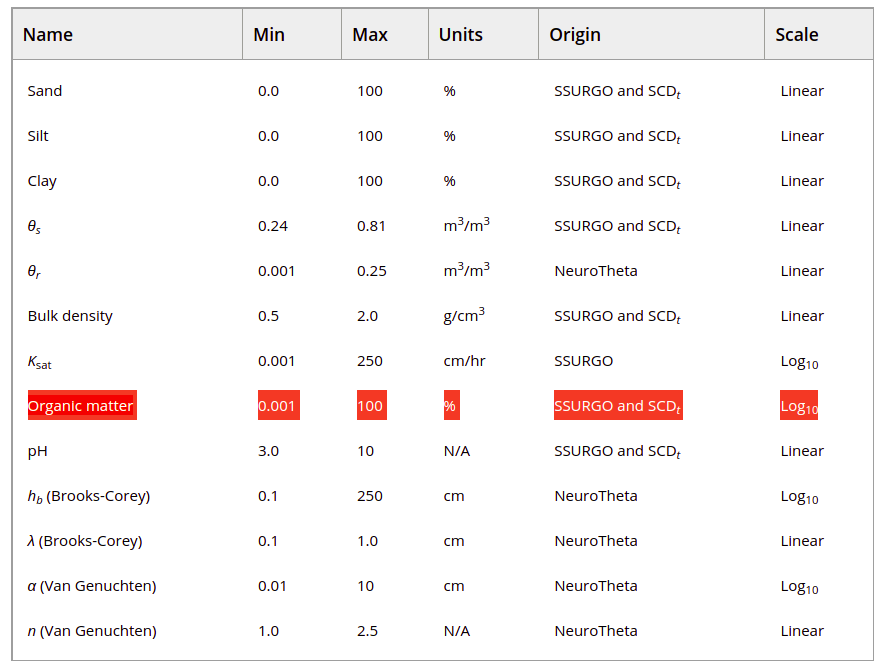


In [39]:
# Let’s define a UDF(User defined function).
def compute_logData(x):
   return np.log(x)

df_data_with_polaris_data['som_stenon'] = df_data_with_polaris_data[['som']].apply(compute_logData, axis=1)

### Data comparison

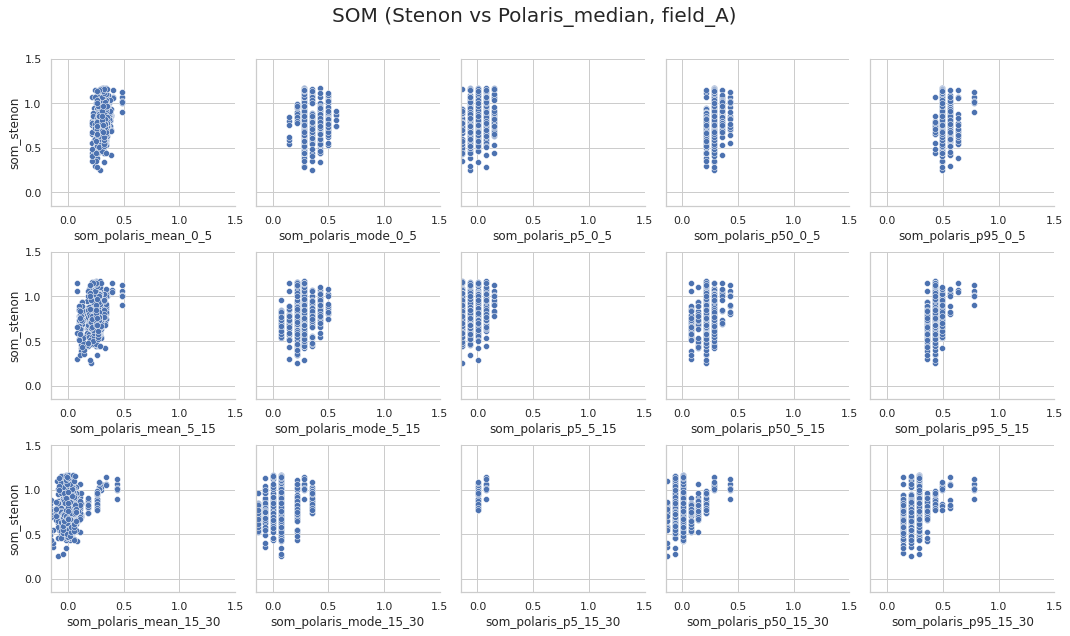

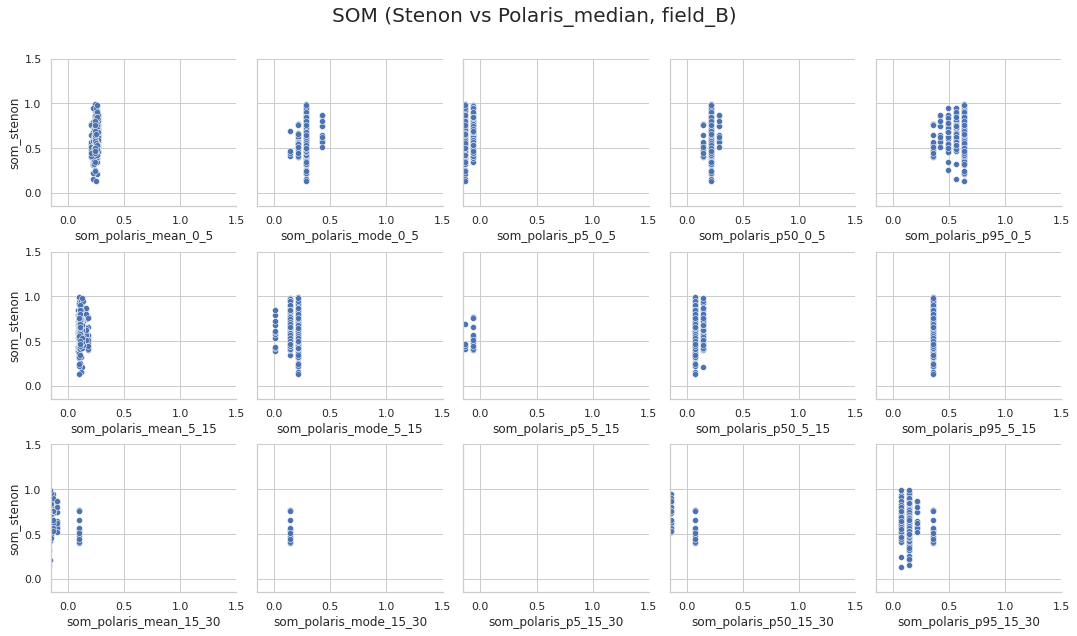

In [40]:
def plot_stenon_polaris(df, 
                        field_name, 
                        y_name = 'som_stenon', 
                        features_names = ['som_polaris_mean_0_5', 'som_polaris_mode_0_5', 'som_polaris_p5_0_5', 'som_polaris_p50_0_5', 'som_polaris_p95_0_5', 
                                          'som_polaris_mean_5_15', 'som_polaris_mode_5_15', 'som_polaris_p5_5_15', 'som_polaris_p50_5_15', 'som_polaris_p95_5_15', 
                                          'som_polaris_mean_15_30', 'som_polaris_mode_15_30', 'som_polaris_p5_15_30', 'som_polaris_p50_15_30', 'som_polaris_p95_15_30']
, 
                        x_lim_max=None,
                        y_lim_max=None
                        ):

  g = sns.FacetGrid(pd.DataFrame(features_names), col=0, col_wrap=5, sharex=False)
  for ax, x_var in zip(g.axes, features_names):
      sns.scatterplot(data=df, x=x_var, y=y_name, ax=ax)
  g.tight_layout()

  g.tight_layout()
  if x_lim_max is not None:
    g.set(xlim=(-0.15, x_lim_max))
  if y_lim_max is not None:
    g.set(ylim=(-0.15, y_lim_max))

  #move overall title up
  g.fig.subplots_adjust(top=0.9)
  g.fig.suptitle('SOM (Stenon vs Polaris_median, {})'.format(field_name), fontsize=20)

  plt.savefig('Compare_with_POLARIS_SOM_{}.png'.format(field_name))
  plt.show()


features_names = df_data_with_polaris_data.columns[3:-1].tolist()

# Plotting: all layers, 0_5, 5_15, 15_30
df_field_A = df_data_with_polaris_data[df_data_with_polaris_data['location']== 'field_A']
df_field_B = df_data_with_polaris_data[df_data_with_polaris_data['location']== 'field_B']

plot_stenon_polaris(df_field_A, features_names=features_names, field_name = 'field_A', x_lim_max=1.5, y_lim_max=1.5)
plot_stenon_polaris(df_field_B, features_names=features_names, field_name = 'field_B', x_lim_max=1.5, y_lim_max=1.5)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


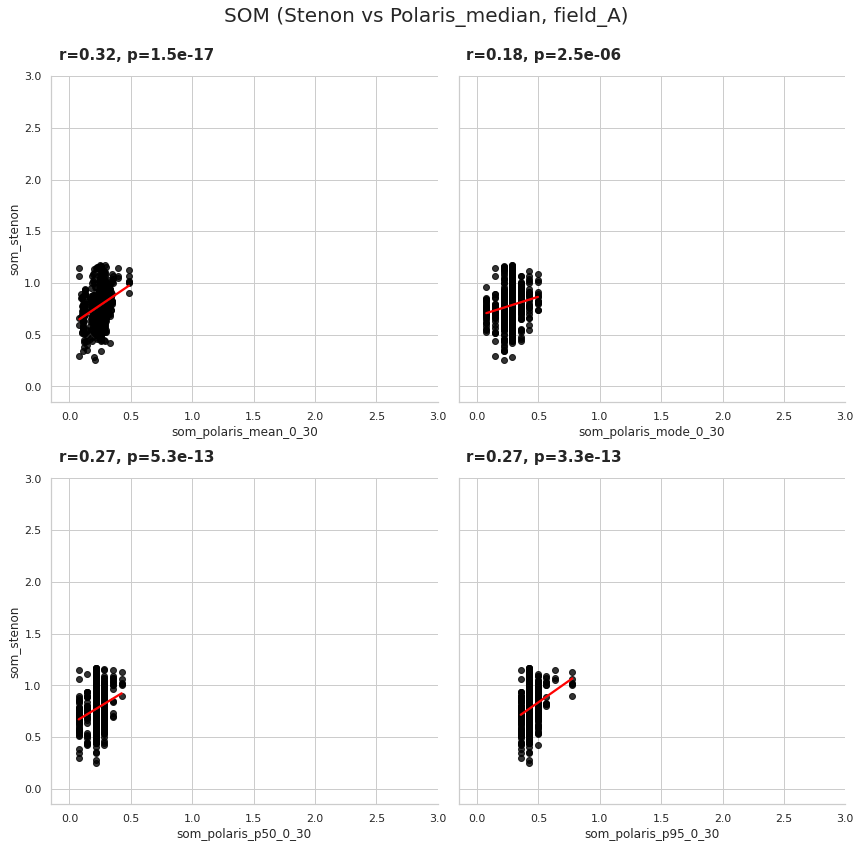

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


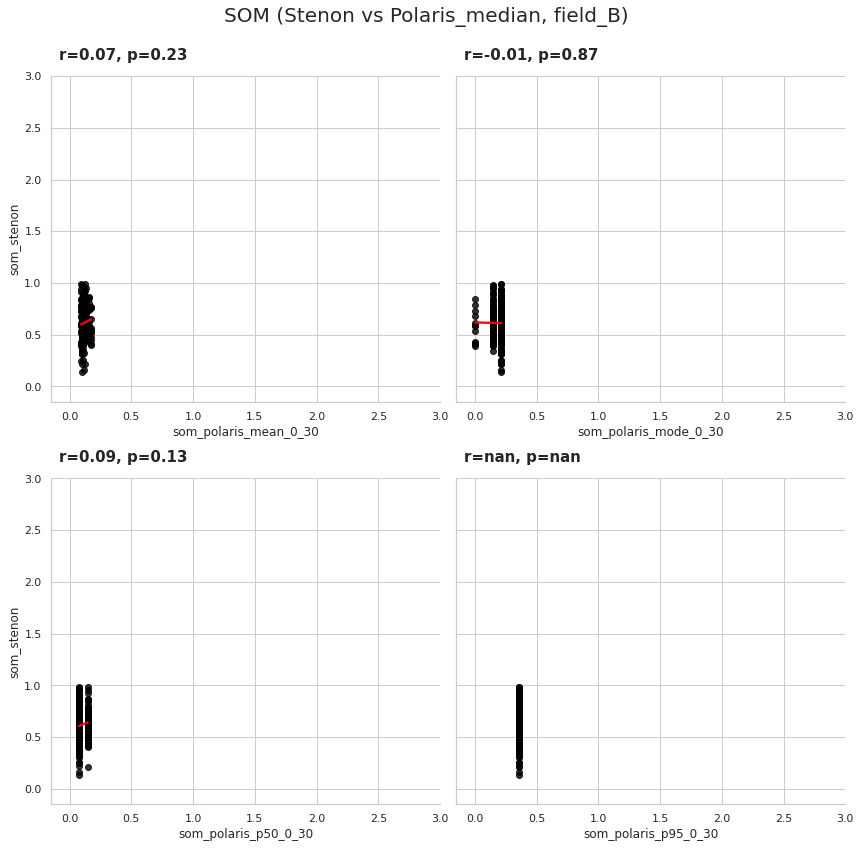

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


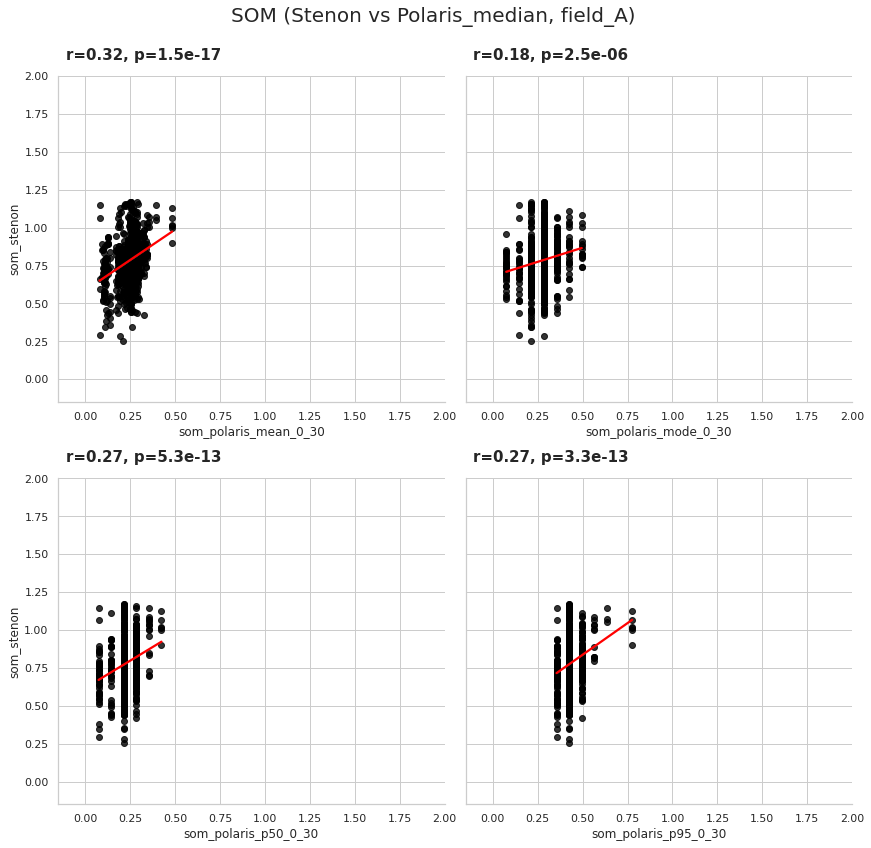

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


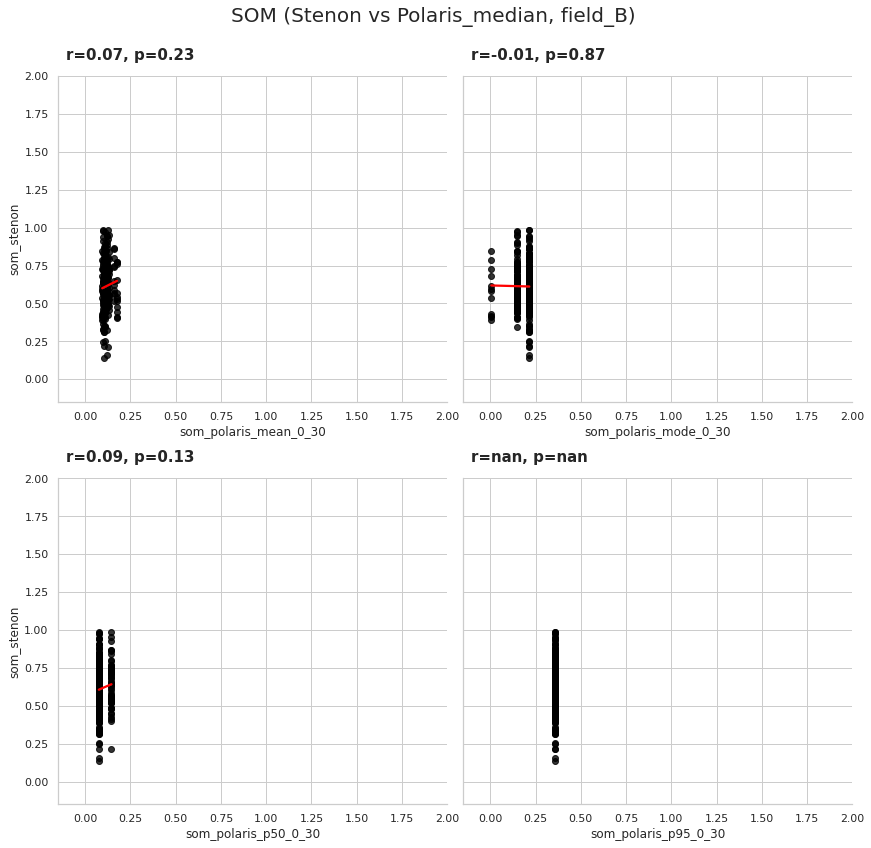

In [41]:
def plot_stenon_polaris_0_30(df, 
                        field_name, 
                        y_name = 'som_stenon', 
                        features_names = ['som_polaris_mean_0_30', 'som_polaris_mode_0_30', 'som_polaris_p50_0_30', 'som_polaris_p95_0_30'], 
                        t_oulier=None,
                        x_lim_max=None,
                        y_lim_max=None
                        ):

  g = sns.FacetGrid(pd.DataFrame(features_names), col=0, col_wrap=2, sharex=False, size = 6)
  for ax, x_var in zip(g.axes, features_names):
    if t_oulier is not None:
      df = df[df[y_name] < t_oulier]

    sns.regplot(data=df, x=x_var, y=y_name, ax=ax, 
                scatter_kws={"color": "black"}, line_kws={"color": "red"},
                scatter = True, ci = 0, fit_reg = True)

    r, p = sp.stats.pearsonr(df[x_var], df[y_name])
    ax.text(.02, 1.05, 'r={:.2f}, p={:.2g}'.format(r, p), weight='bold', fontsize=15, transform=ax.transAxes)

  g.tight_layout()
  if x_lim_max is not None:
    g.set(xlim=(-0.15, x_lim_max))
  if y_lim_max is not None:
    g.set(ylim=(-0.15, y_lim_max))

  #move overall title up
  g.fig.subplots_adjust(top=0.9)
  g.fig.suptitle('SOM (Stenon vs Polaris_median, {})'.format(field_name), fontsize=20)

  plt.savefig('Compare_with_POLARIS_SOM_{}_0_30_median_t_oulier_{}.png'.format(field_name, t_oulier))
  plt.show()


# Combine data from multiple-layers to generate 0_30 layer data
new_features_names = []
ts_hilo_corr_attributes = df_data_with_polaris_data.columns[3:-1].tolist()
for i, name in enumerate(DEFAULT_CHALLENGE_STATISTICS):
  df_data_with_polaris_data["som_polaris_%s_0_30"%name] = [np.median(row) for row in df_data_with_polaris_data[features_names[i::5]].itertuples(index=False)]
  new_features_names.append("som_polaris_%s_0_30"%name)

df_field_A_comb = df_data_with_polaris_data[df_data_with_polaris_data['location']== 'field_A']
df_field_B_comb = df_data_with_polaris_data[df_data_with_polaris_data['location']== 'field_B']


select_features_names = [item for item in new_features_names if item != 'som_polaris_p5_0_30']

# Plotting: a combinned layer: 0_30
# Field A
plot_stenon_polaris_0_30(df_field_A_comb, features_names=select_features_names, field_name='field_A', x_lim_max=3, y_lim_max=3)
plot_stenon_polaris_0_30(df_field_B_comb, features_names=select_features_names, field_name='field_B', x_lim_max=3, y_lim_max=3)
# Field B
plot_stenon_polaris_0_30(df_field_A_comb, features_names=select_features_names, field_name='field_A', t_oulier=2, x_lim_max=2, y_lim_max=2)
plot_stenon_polaris_0_30(df_field_B_comb, features_names=select_features_names, field_name='field_B', t_oulier=2, x_lim_max=2, y_lim_max=2)

### Group Stenon data by location (POLARIS pixel)

In [42]:
def group_points_sample(in_vec, out_vec, interest_cols=['lat', 'lng']):
    from sklearn.cluster import DBSCAN

    # https://medium.com/@agarwalvibhor84/lets-cluster-data-points-using-dbscan-278c5459bee5
    df = gpd.read_file(in_vec)

    X = df[interest_cols].to_numpy()
    dbscan = DBSCAN(eps = 0.00007, min_samples = 2)
    model = dbscan.fit(X)

    labels = model.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)

    df_label = pd.DataFrame(model.labels_, index=df.index, columns = ["group"])
    shape_gdf = pd.concat([df, df_label], axis=1)
    gdf = gpd.GeoDataFrame(shape_gdf, geometry=shape_gdf.geometry)

    if out_vec is not None:
        # Alternatively, you can write GeoJSON to file:
        gdf.to_file(out_vec, driver="GeoJSON")  

    df = gdf.drop(['geometry'], axis=1, errors='ignore')
    
    return df


# Extract data from POLARIS soil database")
geojson_fn = './data.geojson'
in_rst_list =['{}{}'.format(item[1], os.path.basename(item[0])) for item in url_path_lst]
selected_cols=['measurement_ID', 'lat', 'lng', 'location', 'som']
out_geojson_with_polaris = './data_latlng_with_SOM_from_polaris.geojson'

df_latlng_with_polaris_data = ZonalStats(geojson_fn, in_rst_list, out_vec=out_geojson_with_polaris, interest_cols=selected_cols)
out_geojson_with_group_by_location = './data_latlng_with_SOM_from_polaris_group.geojson'

selected_cols = ['lat', 'lng']
df_with_group_by_location = group_points_sample(out_geojson_with_polaris, out_vec=out_geojson_with_group_by_location, interest_cols=selected_cols)
df_with_group_by_location.to_csv('./data_clean_with_group_by_location.csv')

Estimated number of clusters: 155
Estimated number of noise points: 0


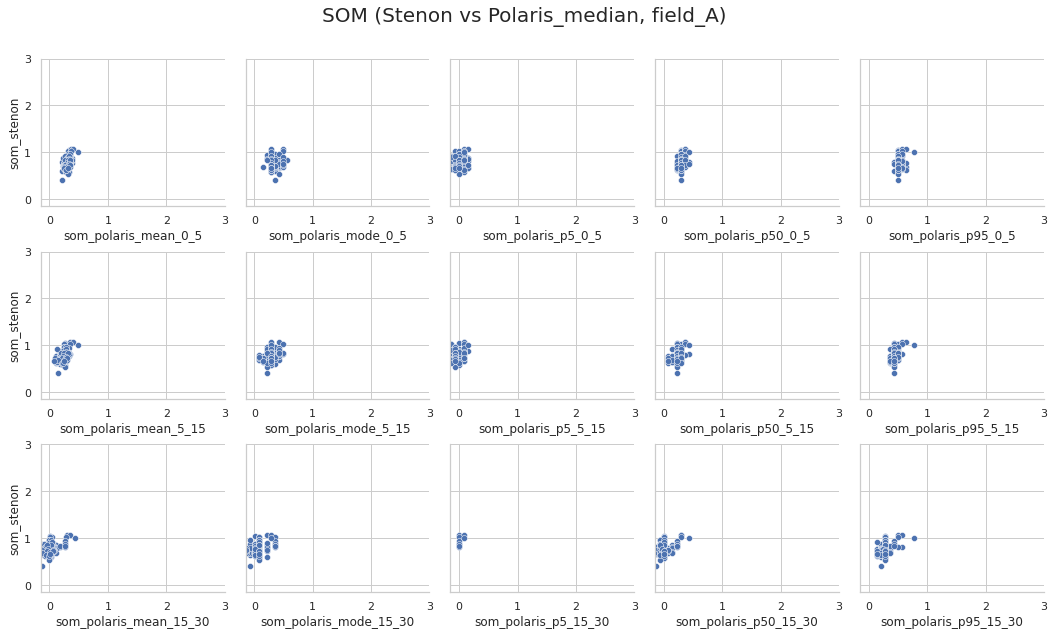

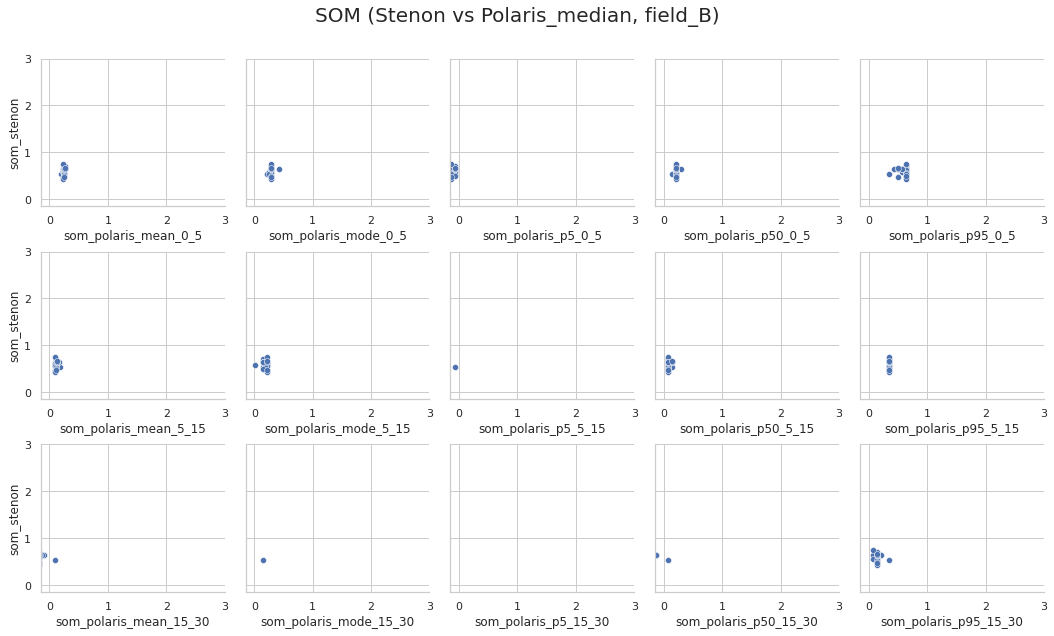

In [43]:
# Field A
df_field_A = df_with_group_by_location[df_with_group_by_location['location'] == 'field_A'].groupby(['group']).median()
df_field_A['som_stenon'] = df_field_A[['som']].apply(compute_logData, axis=1)
features_names = [col for col in df_field_A.columns.tolist() if 'som_polaris_' in col]

# Field B
df_field_B = df_with_group_by_location[df_with_group_by_location['location'] == 'field_B'].groupby(['group']).median()
df_field_B['som_stenon'] = df_field_B[['som']].apply(compute_logData, axis=1)
features_names = [col for col in df_field_B.columns.tolist() if 'som_polaris_' in col]

# Plotting: all layers, 0_5, 5_15, 15_30
plot_stenon_polaris(df_field_A, features_names=features_names, field_name = 'field_A', x_lim_max=3, y_lim_max=3)
plot_stenon_polaris(df_field_B, features_names=features_names, field_name = 'field_B', x_lim_max=3, y_lim_max=3)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


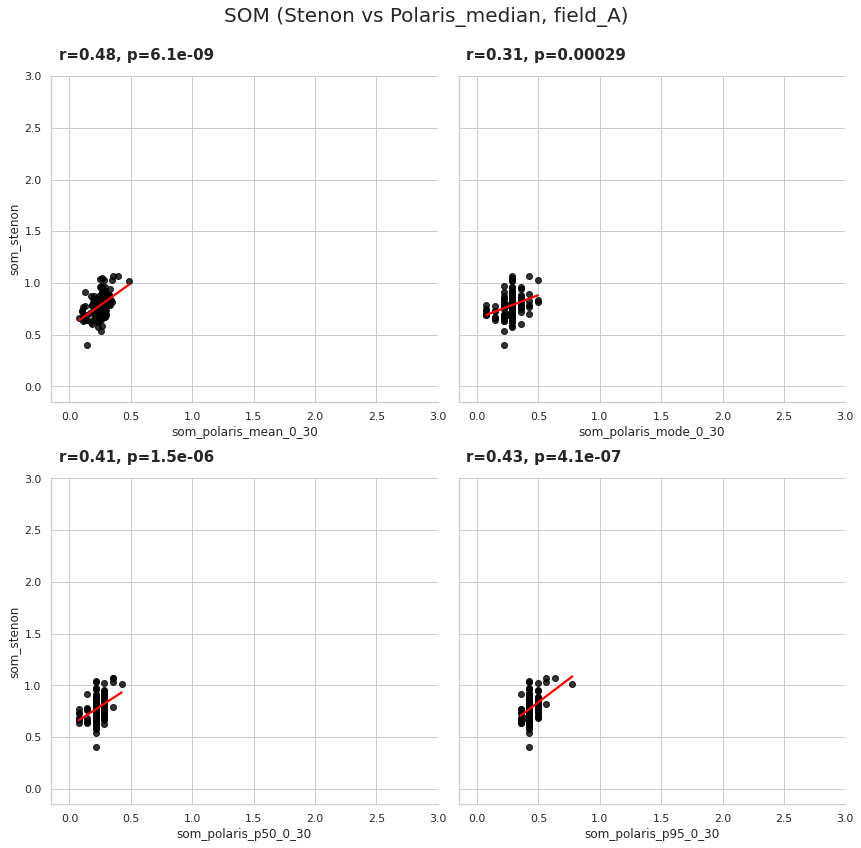

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


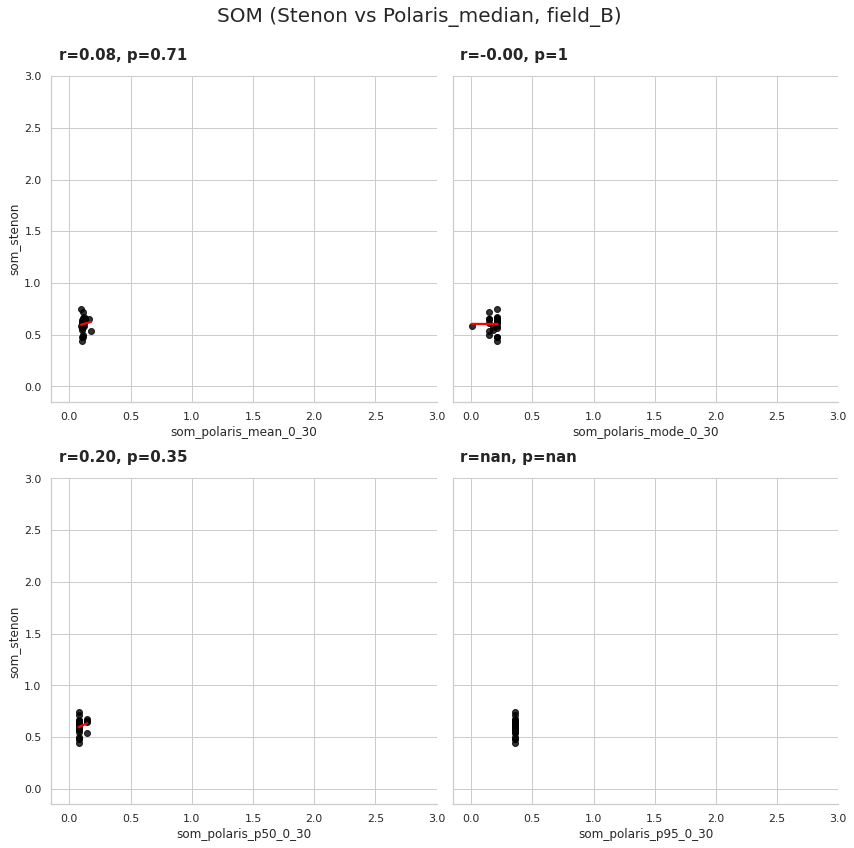

In [44]:
# Combine data from multiple-layers to generate 0_30 layer data
new_features_names = []
for i, name in enumerate(DEFAULT_CHALLENGE_STATISTICS):
  df_with_group_by_location["som_polaris_%s_0_30"%name] = [np.median(row) for row in df_with_group_by_location[features_names[i::5]].itertuples(index=False)]
  new_features_names.append("som_polaris_%s_0_30"%name)

# Field A
df_with_group_by_location_field_A = df_with_group_by_location[df_with_group_by_location['location'] == 'field_A'].groupby(['group']).median()
df_with_group_by_location_field_A['som_stenon'] = df_with_group_by_location_field_A[['som']].apply(compute_logData, axis=1)

# Field B
df_with_group_by_location_field_B = df_with_group_by_location[df_with_group_by_location['location'] == 'field_B'].groupby(['group']).median()
df_with_group_by_location_field_B['som_stenon'] = df_with_group_by_location_field_B[['som']].apply(compute_logData, axis=1)

select_features_names = [item for item in new_features_names if item != 'som_polaris_p5_0_30']
# Plotting: a combinned layer: 0_30
plot_stenon_polaris_0_30(df_with_group_by_location_field_A, features_names=select_features_names, field_name='field_A', x_lim_max=3, y_lim_max=3)
plot_stenon_polaris_0_30(df_with_group_by_location_field_B, features_names=select_features_names, field_name='field_B', x_lim_max=3, y_lim_max=3)

Relationship between input features and target variable

##Regression Model building

In [209]:
''' Data preparation for train the model '''

# Full data (Field_A and Field_B)
train_targets_df = df_data_correct_geo_clean['som']
train_features_df = df_data_correct_geo_clean.filter(regex='nir_')
train_targets_arr = train_targets_df.to_numpy()
train_features_arr = train_features_df.to_numpy()
print (train_targets_arr.shape, train_features_arr.shape)

# Field_A data only
train_field_A_features_df = df_data_correct_geo_clean.loc[df_data_correct_geo_clean['location']=='field_A'].filter(regex='nir_')
train_field_A_targets_df = df_data_correct_geo_clean.loc[df_data_correct_geo_clean['location']=='field_A']['som']
train_field_A_features_arr = train_field_A_features_df.to_numpy()
train_field_A_targets_arr = train_field_A_targets_df.to_numpy()

# Field_B data only
train_field_B_features_df = df_data_correct_geo_clean.loc[df_data_correct_geo_clean['location']=='field_B'].filter(regex='nir_')
train_field_B_targets_df = df_data_correct_geo_clean.loc[df_data_correct_geo_clean['location']=='field_B']['som']
train_field_B_features_arr = train_field_B_features_df.to_numpy()
train_field_B_targets_arr = train_field_B_targets_df.to_numpy()

(974,) (974, 289)


### Relationship between input features and target variable

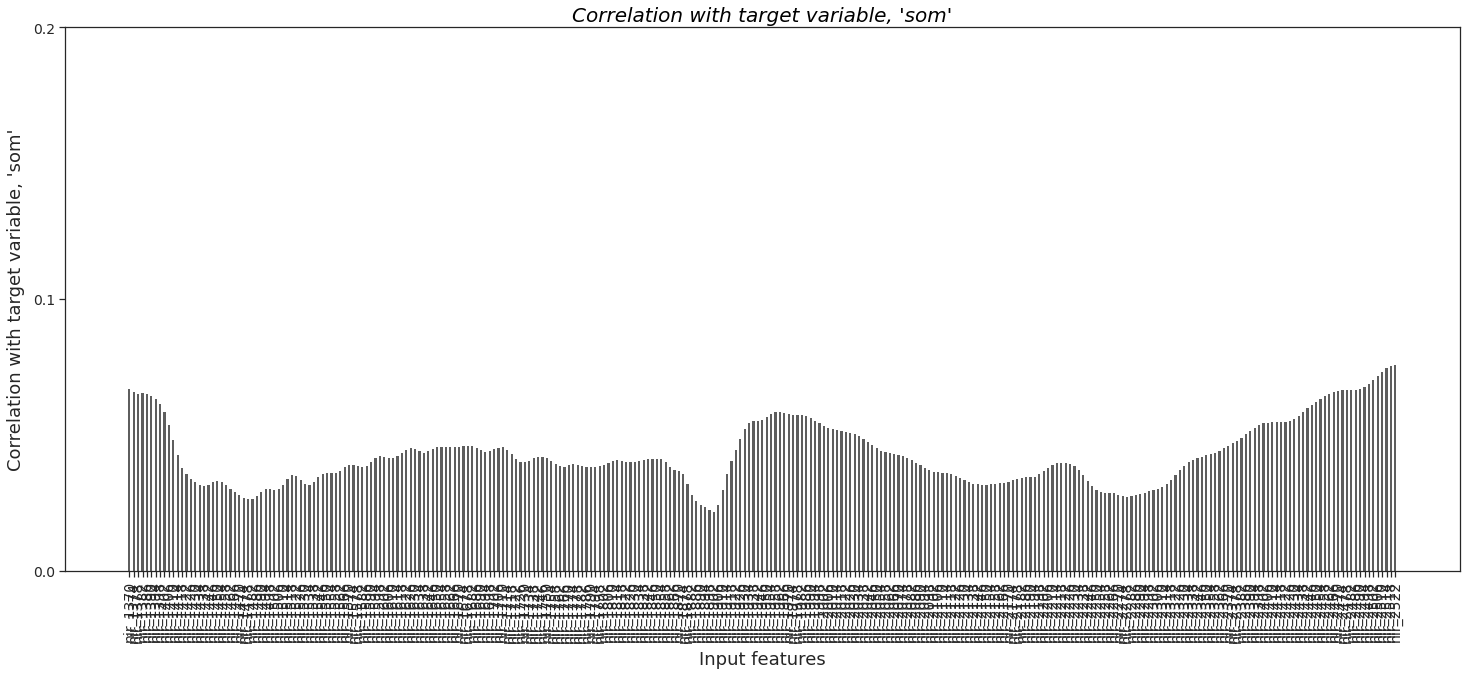

In [134]:
plot_X_labels = train_features_df.columns.tolist()
plot_correls = np.zeros((train_features_arr.shape[-1]))

for i, val in  enumerate(range(0, train_features_arr.shape[-1])):
  b = np.corrcoef(train_features_arr[:, i], train_targets_arr, rowvar=False)
  plot_correls[i] = b[0,1]

# Figure 
fig  = plt.figure(figsize=(25, 10))
ax   = fig.add_subplot(111)
axis_font = {'family':'arial', 'style':'normal', 'size':18}
in_width = 0.5
ar_idxes = np.arange(plot_correls.shape[0])
p1=ax.bar(ar_idxes, plot_correls, in_width, color='k', edgecolor='none', alpha=0.7)
plt.xticks(ar_idxes, plot_X_labels, fontsize=14, rotation=90)
plt.yticks(np.arange(0, 0.3, 0.1), fontsize=14)
ax.set_xlabel('Input features', axis_font, labelpad=8)
ax.set_ylabel("Correlation with target variable, 'som'", axis_font, labelpad=8)
plt.title("Correlation with target variable, 'som'", fontsize = 20, color='Black', fontstyle='italic')
plt.show()

In [47]:
# for st_label, fo_corr in zip(ve_X_labels, ve_correls):
#     print(f"{st_label:20} = {fo_corr:5.2f}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


Text(0.5, 1.0, 'Heat Map: correlation matrix among Input features')

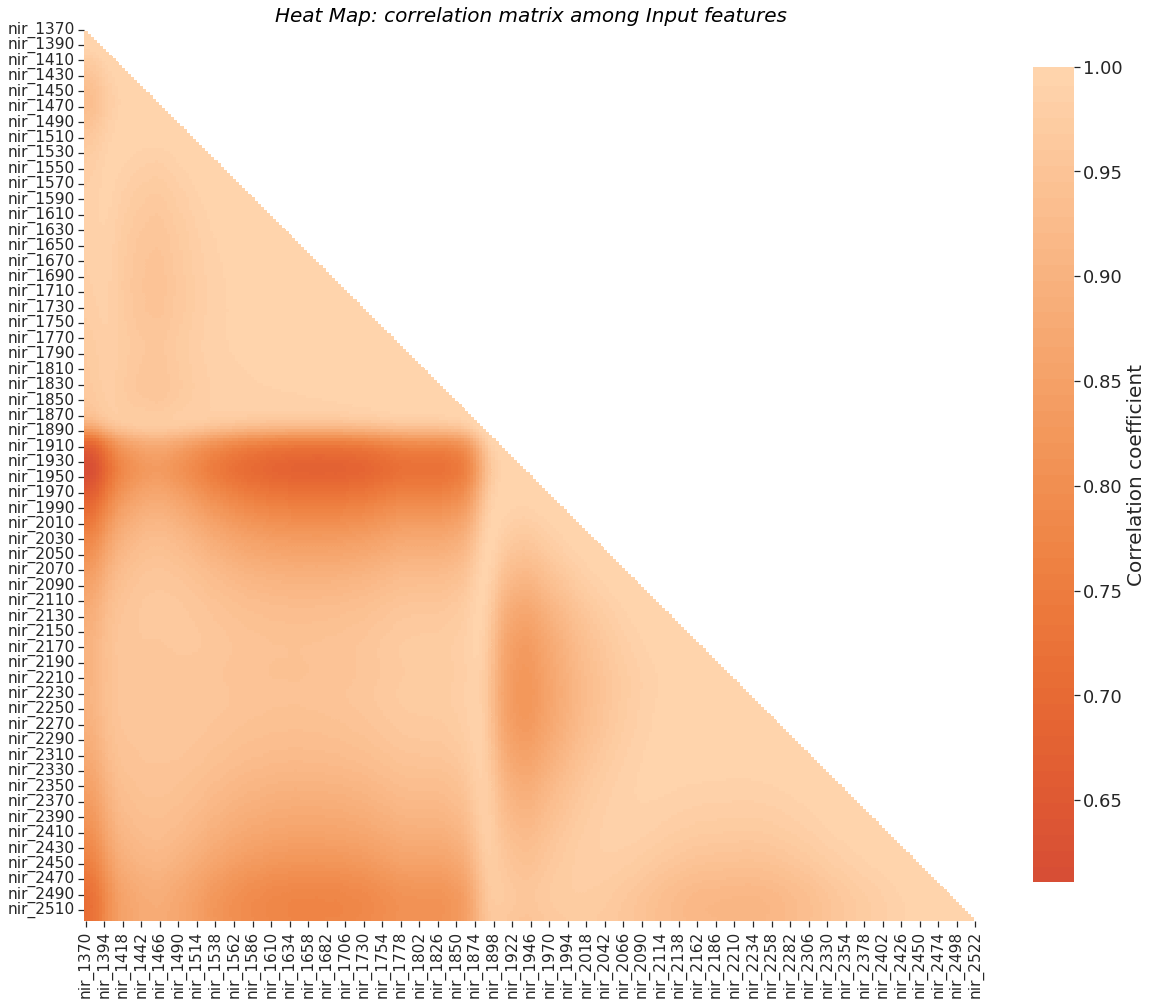

In [260]:
# correlation matrix - contains correlation among attributes
ar_corr_mat = train_features_df.corr().abs()

# Generate a mask for the upper triangle
ar_mask = np.zeros_like(ar_corr_mat, dtype=np.bool)
ar_mask[np.triu_indices_from(ar_mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(100, 10, as_cmap=True)
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax=sns.heatmap(ar_corr_mat, mask=ar_mask, vmax=1.0, 
            center=0, square=True, linewidths=.0, cbar_kws={'label': 'Correlation coefficient', "shrink": .75})

ax.figure.axes[-1].yaxis.label.set_size(20)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)

plt.title("Heat Map: correlation matrix among Input features", fontsize = 20, color='Black', fontstyle='italic')

In [273]:
'''remove highly correlated ones'''
# # Select upper triangle of correlation matrix
# upper = ar_corr_mat.where((np.triu(np.ones(ar_corr_mat.shape), k=1)).astype(bool))
# print (upper.shape)

# # Find features with correlation greater than 0.9
# to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
# print (to_drop)

# # Drop features 
# ar_corr_mat.drop(to_drop, axis=1, inplace=True)
# ar_corr_mat.shape

'remove highly correlated ones'

In [259]:
ar_corr_mat['indicator'] = ar_corr_mat[ar_corr_mat.columns.tolist()].ge(0.6).all(axis=1)
ar_corr_mat[ar_corr_mat['indicator'] == True].shape

(289, 290)

###Strongly related features (an example)

In [ ]:
# sns.set(style="ticks", color_codes=True, font_scale=1.4)
# sns.pairplot(train_features_df.iloc[:, :10])

###Weakly related features

In [ ]:
# sns.set(style="ticks", color_codes=True, font_scale=1.4)
# _temp =  [ 'nir_{}'.format(i) for i in range(1898, 1946, 4)]
# sns.pairplot(train_features_df[_temp])

###Build Model

In [210]:
import pickle

from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# the Linear regression model
from sklearn import linear_model

# the Random forest regression model
from sklearn.ensemble import RandomForestRegressor

# the XGBoost regression model
import xgboost as xgb

models = ['Linear', 'RF', 'XGBoost']


def som_model(features, targets, model_selection='Linear', out_model_fn='all', n_estimators=100, test_size=0):

  if model_selection in models:
    model_build = False
    # Split the data into training and testing sets
    if test_size>0:
      train_features, test_features, train_target, test_targets = train_test_split(features, targets, test_size=test_size)
    else:
      train_features, train_targets = features, targets
      test_features, test_targets = features, targets
  
    if model_selection == 'Linear':
      model = linear_model.LinearRegression()
      model.fit(train_features, train_targets)
      model_build = True
    elif model_selection == 'RF':
      if n_estimators >0 and isinstance(n_estimators, int):
        # Instantiate model with n_estimators decision trees
        model = RandomForestRegressor(n_estimators=n_estimators)
        # Train the model on training data
        model.fit(train_features, train_targets)
        model_build = True
      else:
        print ('n_estimators must be integer!')
    else:
      # convert the dataset into an optimized data structure called Dmatrix that XGBoost supports
      data_dmatrix = xgb.DMatrix(data=train_features,label=train_targets)
      model = xgb.XGBRegressor(objective='reg:squarederror', 
                                colsample_bytree=0.1, 
                                learning_rate=0.1, 
                                max_depth=10, 
                                alpha=5, 
                                n_estimators=80)
      
      model.fit(train_features, train_targets)
      model_build = True

    if model_build:
      pickle.dump(model, open('./{}_{}.pkl'.format(model_selection, out_model_fn), 'wb'))
      return model
  else:
    print ('Model {} is not implimented yet!'.format(model_selection))


out_model_fn = 'all'
for index, model_selection in enumerate(models):
  som_model(train_features_arr, train_targets_arr, model_selection=model_selection, out_model_fn=out_model_fn)

out_model_fn = 'field_A'
for index, model_selection in enumerate(models):
  som_model(train_field_A_features_arr, train_field_A_targets_arr, model_selection=model_selection, out_model_fn=out_model_fn)

out_model_fn = 'field_B'
for index, model_selection in enumerate(models):
  som_model(train_field_B_features_arr, train_field_B_targets_arr, model_selection=model_selection, out_model_fn=out_model_fn)

In [240]:
def model_validation_plot(predictions, estimations, ax, title):

  ### Plot the scatter of the result and R2 calculation:
  r_squared = r2_score(estimations, predictions)
  # Calculate the absolute errors
  errors = abs(predictions - estimations)
  # Calculate mean absolute percentage error (MAPE)
  mape = 100 * (errors / estimations)
  # Calculate and display accuracy
  accuracy = 100 - np.mean(mape)

  # # Errors test
  MAE1 = metrics.mean_absolute_error(estimations, predictions)
  MSE1 = metrics.mean_squared_error(estimations, predictions)
  RMSE1 = np.sqrt(metrics.mean_squared_error(estimations, predictions))
  MAE2 = round(np.mean(errors), 2)
  Acc = round(accuracy, 2)

  x = np.unique(estimations)
  y = np.poly1d(np.polyfit(estimations, predictions, 1))(np.unique(estimations))

  ax.scatter(estimations, predictions, facecolors='none', edgecolors='b')
  ax.plot(x, y, color="r", lw=2)
  ax.set_xlim(1, 4)
  ax.set_ylim(1, 4)
  ax.set_title(title)
  ax.legend(title='MAE1=%.2e, MSE1=%0.2e, RMSE1=%0.2e\nMAE2=%0.2e \nMAPE_Acc=%0.2e'%(MAE1, MSE1, RMSE1, MAE2, Acc))

  # plt.plot([0, 1, 2, 3])
  # plt.text(3.1, 2.95, 'R-squared = %0.2f' % r_squared)
  # plt.xlim(0,4)
  # plt.ylim(0,4)
  # plt.show()

In [ ]:
out_model_fn = 'all'
fig, axs = plt.subplots(3, 3, figsize=(30,15), constrained_layout=True, sharex=True, sharey=True)
# fig.tight_layout(pad=3.0)
for index, model_selection in enumerate(models):  
  pickled_model = pickle.load(open('./{}_{}.pkl'.format(model_selection, out_model_fn), 'rb'))

  # All (Field_A and Field_B)
  predicted_targets = pickled_model.predict(train_features_arr)
  # For Field_A only
  predicted_field_A_targets = pickled_model.predict(train_field_A_features_arr)
  # For Field_B only
  predicted_field_B_targets = pickled_model.predict(train_field_B_features_arr)

  model_validation_plot(predicted_targets, train_targets_arr, axs[index, 0], 'All data [train and evaluate], model: {}'.format(model_selection))
  model_validation_plot(predicted_field_A_targets, train_field_A_targets_arr, axs[index, 1], 'All data [train] Field_A data [evaluate], model: {}'.format(model_selection))
  model_validation_plot(predicted_field_B_targets, train_field_B_targets_arr, axs[index, 2], 'All data [train] Field_B data [evaluate], model: {}'.format(model_selection))

for ax in axs.flat:
    ax.set(xlabel='som [estimated values, %]', ylabel='som [predicted values, %]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(20,25), constrained_layout=True, sharex=True, sharey=True)
from decimal import Decimal
# fig.tight_layout(pad=3.0)
out_model_fn = 'field_A'
for index, model_selection in enumerate(models):
  pickled_model = pickle.load(open('./{}_{}.pkl'.format(model_selection, out_model_fn), 'rb'))
  # For Field_A only
  predicted_field_A_targets = pickled_model.predict(train_field_A_features_arr)
  # For Field_B only
  predicted_field_B_targets = pickled_model.predict(train_field_B_features_arr)

  model_validation_plot(predicted_field_A_targets, train_field_A_targets_arr, axs[index, 0], '{} data [train and evaluate], model: {}'.format(out_model_fn, model_selection))
  model_validation_plot(predicted_field_B_targets, train_field_B_targets_arr, axs[index, 1], '{} [train] field_B data [evaluate], model: {}'.format(out_model_fn, model_selection))

for ax in axs.flat:
    ax.set(xlabel='som [estimated values, %]', ylabel='som [predicted values, %]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(20,25), constrained_layout=True, sharex=True, sharey=True)
# fig.tight_layout(pad=3.0)
out_model_fn = 'field_B'
for index, model_selection in enumerate(models):
  pickled_model = pickle.load(open('./{}_{}.pkl'.format(model_selection, out_model_fn), 'rb'))
  # For Field_A only
  predicted_field_A_targets = pickled_model.predict(train_field_A_features_arr)
  # For Field_B only
  predicted_field_B_targets = pickled_model.predict(train_field_B_features_arr)

  model_validation_plot(predicted_field_B_targets, train_field_B_targets_arr, axs[index, 0], '{} data [train and evaluate], model: {}'.format(out_model_fn, model_selection))
  model_validation_plot(predicted_field_A_targets, train_field_A_targets_arr, axs[index, 1], '{} [train] field_A data [evaluate], model: {}'.format(out_model_fn, model_selection))

for ax in axs.flat:
    ax.set(xlabel='som [estimated values, %]', ylabel='som [predicted values, %]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

###Outlier removal

In [ ]:
df_data_correct_geo_field_A_filtered = outlier_removal(df_data_correct_geo, 'field_A')
df_data_correct_geo_field_B_filtered = outlier_removal(df_data_correct_geo, 'field_B')

df_data_correct_geo_clean = pd.concat([df_data_correct_geo_field_A_filtered, df_data_correct_geo_field_B_filtered])
df_data_correct_geo_clean.to_csv('./data_clean.csv')

In [ ]:
train_data[:, 0].shape, train_targets.shape

In [ ]:
### import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error
import math
from sklearn import metrics

# build Random forest model:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Import the Random forest regression model:
from sklearn.ensemble import RandomForestRegressor

def som_train(df, label_col='som', features_regex='nir_', n_estimators=100, test_size=50, random_state=0):

  labels= df[label_col].to_numpy()
  features = df.filter(regex=features_regex).to_numpy()

  # Split the data into training and testing sets
  train_features, test_features, train_labels, test_labels=train_test_split(features, labels, test_size=test_size, random_state=random_state)

  # Instantiate model with n_estimators decision trees
  rf = RandomForestRegressor(n_estimators=n_estimators)

  # Train the model on training data
  rf.fit(train_features, train_labels)

  # Use the forest's predict method on the test data:
  predictions = rf.predict(test_features)

  # Calculate the absolute errors
  errors = abs(test_labels - predictions)

  # Print out the mean absolute error (mae)
  print('-Mean Absolute Error:', round(np.mean(errors), 2), '%')

  # Calculate mean absolute percentage error (MAPE):
  mape = 100 * (errors / test_labels)

  # Calculate and display accuracy
  accuracy = 100 - np.mean(mape)
  print('-MAPE Accuracy:', round(accuracy, 2), '%.')

  ### Calculate RMSE 
  mse = mean_squared_error(test_labels, predictions)
  rmse = math.sqrt(mse)
  print ('-RMSE Error: ',rmse)

  ######## Errors test
  print('Mean Absolute Error1:', metrics.mean_absolute_error(test_labels, predictions))
  print('Mean Squared Error1:', metrics.mean_squared_error(test_labels, predictions))
  print('Root Mean Squared Error1:', np.sqrt(metrics.mean_squared_error(test_labels, predictions)))

  ### Plot the scatter of the result and R2 calculation:
  r_squared = r2_score(test_labels, predictions)

  plt.figure(figsize=(10,8))
  plt.scatter(test_labels, predictions, c='k')
  plt.xlabel('Actual values')
  plt.ylabel('Predicted values')

  x = np.unique(test_labels)
  y = np.poly1d(np.polyfit(test_labels, predictions, 1))(np.unique(test_labels))
  plt.plot(x, y, color="r", lw=2, label="extended")
  plt.plot([0, 1, 2, 3, 4])
  plt.text(4.1, 3.95, 'R-squared = %0.2f' % r_squared)
  plt.xlim(0,4)
  plt.ylim(0,4)
  plt.show()

In [ ]:
# For ALL
som_train(df_data_correct_geo_clean)
# df_data_correct_geo_clean.columns

In [ ]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [ ]:
train_data.shape, test_data.shape, train_targets.shape

In [ ]:
train_targets = df_data_correct_geo_clean['som'].to_numpy()
features_regex = 'nir_'
train_data = df_data_correct_geo_clean.filter(regex=features_regex).to_numpy()

test_data = train_data

In [ ]:
train_data.shape, test_data.shape, train_targets.shape

In [ ]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

In [ ]:
all_scores

In [ ]:
np.mean(all_scores)

In [ ]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [ ]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [ ]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [ ]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

In [ ]:
model = build_model()
model.fit(train_data, train_targets, epochs=130, batch_size=16, verbose=0)

In [ ]:
df_test = df_data_correct_geo_clean.loc[df_data_correct_geo_clean['location'] == 'field_A']
test_targets = df_test['som'].to_numpy()
features_regex = 'nir_'
test_data = df_test.filter(regex=features_regex).to_numpy()

In [ ]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

In [ ]:
test_mae_score

In [ ]:
predictions = model.predict(test_data)
# test_targets

In [ ]:
  ### Plot the scatter of the result and R2 calculation:
  predictions = predictions
  test_labels = test_targets
  r_squared = r2_score(test_labels, predictions)

  plt.figure(figsize=(10,8))
  plt.scatter(test_labels, predictions, c='k')
  plt.xlabel('Actual values')
  plt.ylabel('Predicted values')

  x = np.unique(test_labels)
  y = np.poly1d(np.polyfit(test_labels.flatten(), predictions.flatten(), 1))(np.unique(test_labels))
  plt.plot(x, y, color="r", lw=2, label="extended")
  # plt.plot([0, 1, 2, 3, 4])
  # plt.text(4.1, 3.95, 'R-squared = %0.2f' % r_squared)
  # plt.xlim(0,4)
  # plt.ylim(0,4)
  plt.show()